# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings("ignore")

# Upload Data

In [3]:
trian_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")

In [4]:
trian_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195


### Data Preprocess

In [11]:
train_X, train_y = trian_df.iloc[:, 1:].values, trian_df.iloc[:,0].values
train_X.shape, train_y.shape

((27455, 784), (27455,), (7172, 784), (7172,))

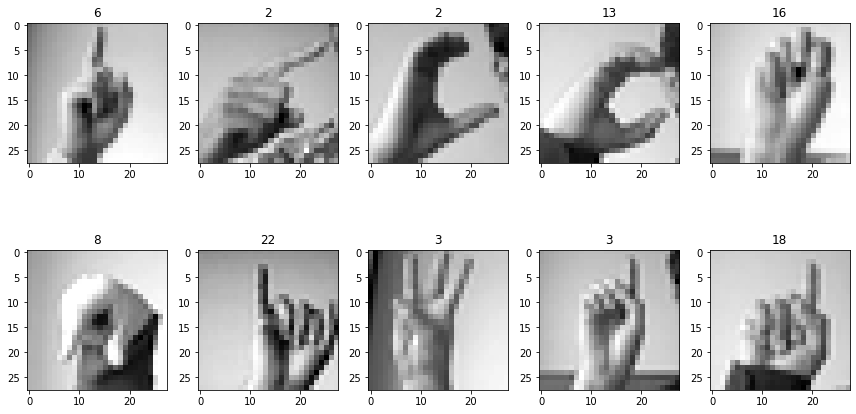

In [12]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(12, 8)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(train_X[k].reshape((28,28)), cmap="gray")
        k += 1
        ax[i,j].set_title(train_y[k])
    plt.tight_layout() 

In [13]:
# scale images to [0,1] interval
train_X = train_X / 255

## Build Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
            
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model Building

In [15]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=200, z_dim=20):
        super().__init__()
        # for encoder
        self.img_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mu = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(hidden_dim, z_dim)
        
        # for decoder
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_img = nn.Linear(hidden_dim, input_dim)
        
    def encoder(self, x):
        h = F.relu(self.img_to_hidden(x))
        mu, sigma = self.hidden_to_mu(h), self.hidden_to_sigma(h)
        return mu, sigma
        
    def decoder(self, z):
        h = F.relu(self.z_to_hidden(z))
        return torch.sigmoid(self.hidden_to_img(h))
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma * epsilon
        x_reconstructed = self.decoder(z_reparametrized)
        return x_reconstructed, mu, sigma
    
# # just to test if everything works
# if __name__ == "__main__":
#     # for 28x28 images
#     x = torch.randn(36, 28*28)
#     VAE = VariationalAutoEncoder(input_dim=784)
#     x_reconstructed, mu, sigma = VAE(x)
#     print(x_reconstructed.shape)
#     print(mu.shape)
#     print(sigma.shape)

### Check Architecture & Size

In [16]:
model = VariationalAutoEncoder(input_dim=784)
print(model)

VariationalAutoEncoder(
  (img_to_hidden): Linear(in_features=784, out_features=200, bias=True)
  (hidden_to_mu): Linear(in_features=200, out_features=20, bias=True)
  (hidden_to_sigma): Linear(in_features=200, out_features=20, bias=True)
  (z_to_hidden): Linear(in_features=20, out_features=200, bias=True)
  (hidden_to_img): Linear(in_features=200, out_features=784, bias=True)
)


In [17]:
summary(model, input_size=(64, 784))

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoEncoder                   [64, 784]                 --
├─Linear: 1-1                            [64, 200]                 157,000
├─Linear: 1-2                            [64, 20]                  4,020
├─Linear: 1-3                            [64, 20]                  4,020
├─Linear: 1-4                            [64, 200]                 4,200
├─Linear: 1-5                            [64, 784]                 157,584
Total params: 326,824
Trainable params: 326,824
Non-trainable params: 0
Total mult-adds (M): 20.92
Input size (MB): 0.20
Forward/backward pass size (MB): 0.63
Params size (MB): 1.31
Estimated Total Size (MB): 2.13

## Training

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [205]:
input_dim = 784
hidden_dim = 200
z_dim = 20
num_epochs = 1000
batch_size = 64
lr_rate = 10e-7 

In [21]:
model = VariationalAutoEncoder(input_dim=784)
model = model.to(device)

In [213]:
loss_fn = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
train_dataset = CustomDataset(X=train_X, y=train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [194]:
# save loses after each epoch for graph
loss_ls = []

### Training Loop

In [207]:
bar_1 = tqdm(position=0, desc='epoch bar', total = num_epochs)
bar_2 = tqdm(position=1, desc='Batch bar', total = len(train_loader), leave=True)

for n_epoch in range(num_epochs):
#     loop = tqdm(enumerate(train_loader))
    train_epoch_loss = 0
    # in this case we do not need labels, so let's denote is as _
    for n, (x, _) in enumerate(train_loader):
        # forward pass
        x = x.float().to(device)
        x_reconstructed, mu, sigma = model(x)

        # calculate loss
        recons_loss = loss_fn(x_reconstructed, x)
        KL_dic = - torch.sum(1 + torch.log(sigma.pow(2))- mu.pow(2) - sigma.pow(2))
        
        # backpropagation
        loss = recons_loss + KL_dic
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_epoch_loss+=loss.item()

        bar_2.update(1)
        bar_2.set_description(f"loss:{loss.item():.2f}")
    loss_ls.append(train_epoch_loss/len(train_loader))
    if n_epoch % 10 == 0:
        print(f"Epoch: {n_epoch} | average_loss: {train_epoch_loss/len(train_loader)}")
#     if n_epoch+1 % 100 == 0:
#         lr_rate = lr_rate / 5
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    
    bar_1.update(1)
    bar_2.reset()

### Training Graph

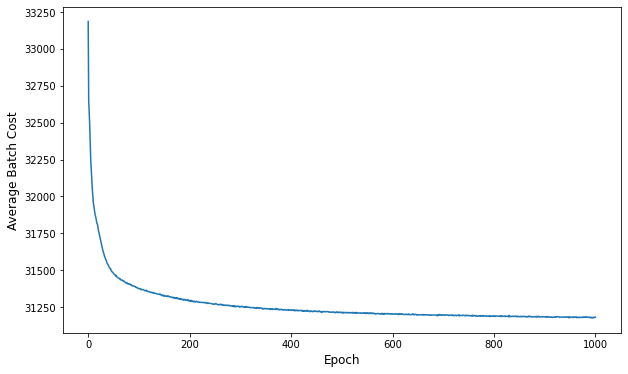

In [215]:
plt.figure(figsize=(10,6))
plt.plot(loss_ls)
plt.xlabel("Epoch", size=12)
plt.ylabel("Average Batch Cost", size=12)
plt.show()

# Results

### Generate New Images

In [223]:
images = []
idx = 0
for x, y in train_dataset:
    x = torch.Tensor(x).to(device)
    if y == idx:
        images.append(x)
        idx +=1
    if idx == 10:
        break

encodings = []
for d in range(8):
    with torch.no_grad():
        mu, sigma = model.encoder(images[d].view(1, 784))
    encodings.append((mu, sigma))

In [225]:
examples = {}
with torch.no_grad():
    for idx in range(8):
        for j in range(3):
            mu, sigma = encodings[idx]
            epsilon = torch.randn_like(sigma)
            z = mu + sigma * epsilon
            out = model.decoder(z)
            out = out.view(28, 28)
            examples[f"ex_{j+1}, shape_{idx}"] = out

### Plot Generated Images

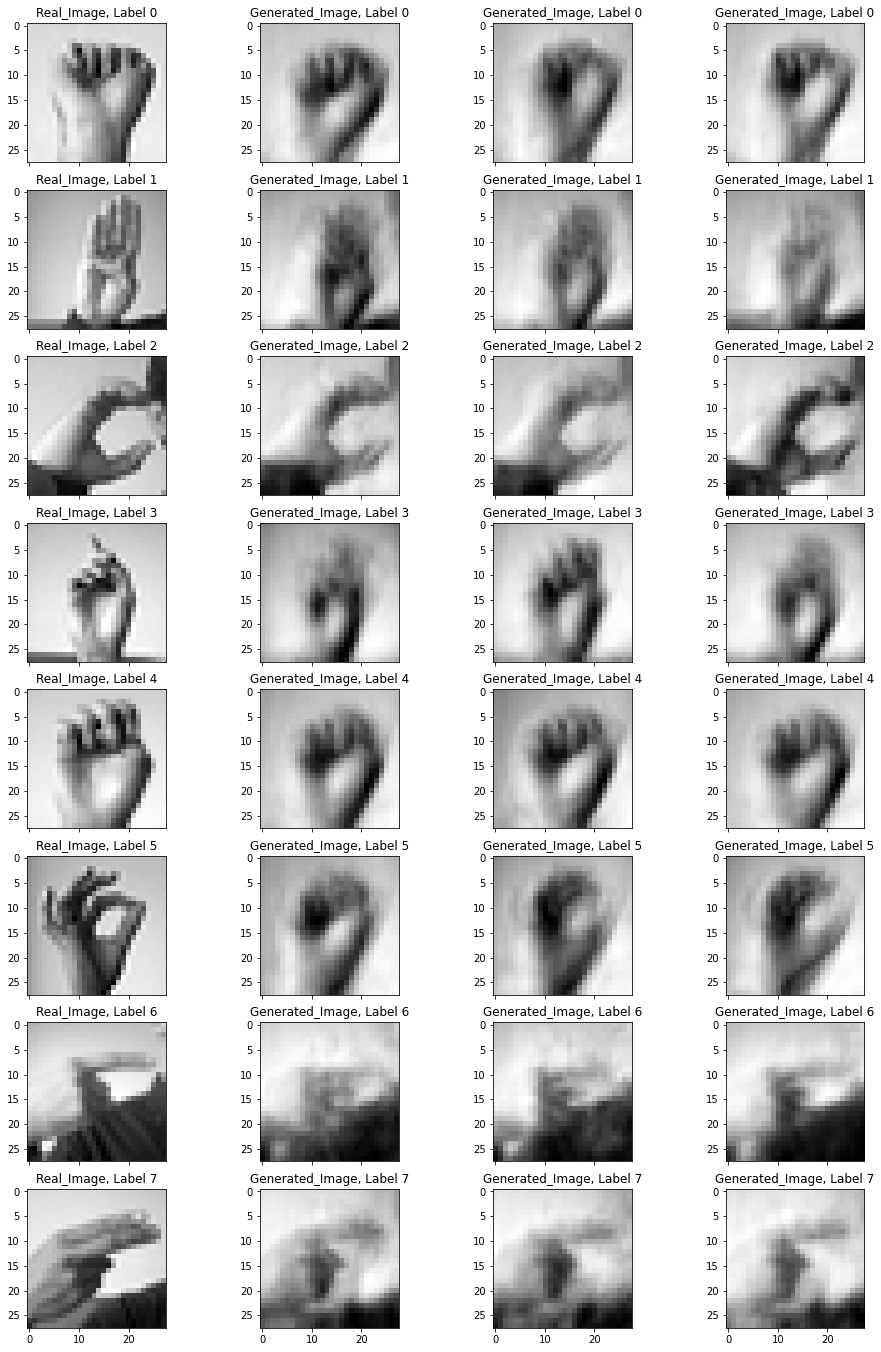

In [229]:
f, ax = plt.subplots(8, 4, sharex=True, figsize=(16,24))
for i in range(8):
    for j in range(4):
        if j == 0:
            ax[i,j].imshow(images[i].to("cpu").view(28,28), cmap="gray")
            ax[i,j].set_title(f"Real_Image, Label {i}")
        else:
            ax[i,j].imshow(examples[f"ex_{j}, shape_{i}"].to("cpu").view(28,28).numpy(), cmap="gray")
            ax[i,j].set_title(f"Generated_Image, Label {i}")